In [59]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

In [60]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection, metrics
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [61]:
train_file='D:\\My Personal Documents\\Learnings\\Data Science\\Data Sets\\AmericanExpress\\train.csv'
test_file='D:\\My Personal Documents\\Learnings\\Data Science\\Data Sets\\AmericanExpress\\test.csv'
user_logs='D:\\My Personal Documents\\Learnings\\Data Science\\Data Sets\\AmericanExpress\\historical_user_logs.csv'

train=pd.read_csv(train_file)
test=pd.read_csv(test_file)
user_log=pd.read_csv(user_logs)

In [62]:
is_click_count= len(train[train.is_click==1])
non_click_indices = train[train.is_click==0].index
random_indices = np.random.choice(non_click_indices,is_click_count*5, replace=False)
click_indices = train[train.is_click==1].index
under_sample_indices = np.concatenate([click_indices,random_indices])
under_sample = train.loc[under_sample_indices]
train=under_sample

In [63]:
user_log_view=user_log[user_log.action=='view']
user_log_interest=user_log[user_log.action=='interest']

In [64]:
user_log_interest=user_log_interest.groupby(['user_id','product']).action.count().reset_index()

In [65]:
user_log_interest.rename(columns={'action': 'interest'}, inplace=True)
user_log_interest.head()

,user_id,product,interest
0,19,D,1
1,19,F,2
2,19,G,2
3,26,H,1
4,30,H,1


In [66]:
user_log_view=user_log_view.groupby(['user_id','product']).action.count().reset_index()

In [67]:
user_log_view.rename(columns={'action': 'view'}, inplace=True)
user_log_view.head()


,user_id,product,view
0,4,A,3
1,4,B,1
2,4,H,1
3,4,I,2
4,19,A,14


In [68]:
train['source']='train'
test['source']='test'
train=train.append(test)
train.info()


C:\Amrendra\Anaconda\lib\site-packages\pandas\core\frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 316844 entries, 38 to 128857
Data columns (total 16 columns):
DateTime                  316844 non-null object
age_level                 303772 non-null float64
campaign_id               316844 non-null int64
city_development_index    231603 non-null float64
gender                    303772 non-null object
is_click                  187986 non-null float64
product                   316844 non-null object
product_category_1        316844 non-null int64
product_category_2        91984 non-null float64
session_id                316844 non-null int64
source                    316844 non-null object
user_depth                303772 non-null float64
user_group_id             303772 non-null float64
user_id                   316844 non-null int64
var_1                     316844 non-null int64
webpage_id                316844 non-null int64
dtypes: float64(6), int64(6), object(4)
memory usage: 41.1+ MB


In [69]:
train=pd.merge(train,user_log_interest,how='left', on=['user_id','product'])
train=pd.merge(train,user_log_view,how='left', on=['user_id','product'])

In [70]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 316844 entries, 0 to 316843
Data columns (total 18 columns):
DateTime                  316844 non-null object
age_level                 303772 non-null float64
campaign_id               316844 non-null int64
city_development_index    231603 non-null float64
gender                    303772 non-null object
is_click                  187986 non-null float64
product                   316844 non-null object
product_category_1        316844 non-null int64
product_category_2        91984 non-null float64
session_id                316844 non-null int64
source                    316844 non-null object
user_depth                303772 non-null float64
user_group_id             303772 non-null float64
user_id                   316844 non-null int64
var_1                     316844 non-null int64
webpage_id                316844 non-null int64
interest                  54854 non-null float64
view                      254408 non-null float64
dtypes:

In [71]:
t_click1=train[train.is_click==1]
train=train.append(t_click1)
train=train.append(t_click1)

In [72]:
train.isnull().sum()

DateTime                       0
age_level                  15620
campaign_id                    0
city_development_index    102205
gender                     15620
is_click                  128858
product                        0
product_category_1             0
product_category_2        275150
session_id                     0
source                         0
user_depth                 15620
user_group_id              15620
user_id                        0
var_1                          0
webpage_id                     0
interest                  313720
view                       73956
dtype: int64

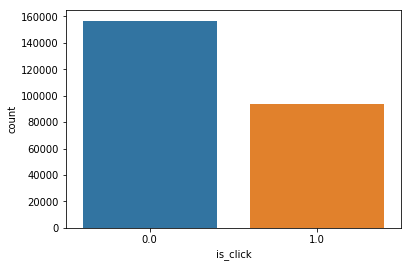

In [73]:
sb.countplot(train.is_click)

In [74]:
#plt.figure(figsize=(12,6))
#sb.countplot(x='is_click', hue='product', data=train)

In [75]:
#plt.figure(figsize=(12,6))
#sb.countplot(x='is_click', hue='gender', data=train)

In [76]:
#plt.figure(figsize=(12,6))
#sb.countplot(x='is_click', hue='var_1', data=train)

In [77]:
#plt.figure(figsize=(12,6))
#sb.countplot(x='var_1', hue='is_click', data=train)

In [78]:
train_label= train.is_click


In [79]:
train.gender=train.gender.fillna('Unknown')

In [80]:
train.city_development_index= train.city_development_index.fillna(method='pad')

In [81]:
train.age_level= train.age_level.fillna(method='pad')

In [82]:
train.user_depth= train.user_depth.fillna(method='pad')

In [83]:
train.user_group_id= train.user_group_id.fillna(method='pad')

In [84]:
train.view=train.view.fillna(0)
train.interest=train.interest.fillna(0)

In [85]:
train.DateTime = pd.to_datetime(train.DateTime)

In [86]:
test.DateTime = pd.to_datetime(test.DateTime)

In [87]:
train=pd.get_dummies(train,columns=['gender','product'])

In [88]:
import datetime

train_dt = datetime.datetime(2017, 7, 7)
test_dt = datetime.datetime(2017, 7, 9)

print(test_dt)

2017-07-09 00:00:00


In [89]:
(test_dt-train_dt).total_seconds()

172800.0

In [90]:
train['duration']= train.DateTime.apply(lambda x: pd.Timedelta(train_dt-x).total_seconds()/60)
test['duration']= test.DateTime.apply(lambda x: pd.Timedelta(test_dt-x).total_seconds()/60)

In [91]:
train.head()

,DateTime,age_level,campaign_id,city_development_index,is_click,product_category_1,product_category_2,session_id,source,user_depth,...,product_B,product_C,product_D,product_E,product_F,product_G,product_H,product_I,product_J,duration
0,2017-07-02 00:05:00,2.0,359520,NaN,1.0,3,NaN,489923,train,2.0,...,0,0,0,0,0,0,1,0,0,7195.0
1,2017-07-02 00:07:00,3.0,98970,4.0,1.0,4,NaN,419802,train,3.0,...,0,0,0,0,0,1,0,0,0,7193.0
2,2017-07-02 00:08:00,3.0,359520,4.0,1.0,4,NaN,145098,train,3.0,...,0,1,0,0,0,0,0,0,0,7192.0
3,2017-07-02 00:13:00,2.0,405490,4.0,1.0,3,NaN,102183,train,3.0,...,0,1,0,0,0,0,0,0,0,7187.0
4,2017-07-02 00:13:00,2.0,405490,3.0,1.0,3,NaN,72843,train,3.0,...,0,1,0,0,0,0,0,0,0,7187.0


In [92]:
train= train.drop(['DateTime','user_id','product_category_2','session_id'],axis=1)

In [93]:
train.head()

,age_level,campaign_id,city_development_index,is_click,product_category_1,source,user_depth,user_group_id,var_1,webpage_id,...,product_B,product_C,product_D,product_E,product_F,product_G,product_H,product_I,product_J,duration
0,2.0,359520,NaN,1.0,3,train,2.0,2.0,0,13787,...,0,0,0,0,0,0,1,0,0,7195.0
1,3.0,98970,4.0,1.0,4,train,3.0,9.0,1,6970,...,0,0,0,0,0,1,0,0,0,7193.0
2,3.0,359520,4.0,1.0,4,train,3.0,3.0,0,13787,...,0,1,0,0,0,0,0,0,0,7192.0
3,2.0,405490,4.0,1.0,3,train,3.0,2.0,0,60305,...,0,1,0,0,0,0,0,0,0,7187.0
4,2.0,405490,3.0,1.0,3,train,3.0,2.0,1,60305,...,0,1,0,0,0,0,0,0,0,7187.0


In [94]:
test=train[train.source=='test']
train=train[train.source=='train']


In [95]:
train.drop('source',axis=1,inplace=True)

In [96]:
test.drop('source',axis=1,inplace=True)

In [97]:
train_label=train.is_click

In [98]:
train=train[~(train.city_development_index.isna())]
train.isna().sum()

age_level                 0
campaign_id               0
city_development_index    0
is_click                  0
product_category_1        0
user_depth                0
user_group_id             0
var_1                     0
webpage_id                0
interest                  0
view                      0
gender_Female             0
gender_Male               0
gender_Unknown            0
product_A                 0
product_B                 0
product_C                 0
product_D                 0
product_E                 0
product_F                 0
product_G                 0
product_H                 0
product_I                 0
product_J                 0
duration                  0
dtype: int64

In [99]:
y_train=train['is_click']
x_train=train.drop(['is_click'],axis=1).values
x_test=test.drop(['is_click'],axis=1).values
#y_test=titanic_result.Survived

In [109]:
train.describe()

,age_level,campaign_id,city_development_index,is_click,product_category_1,user_depth,user_group_id,var_1,webpage_id,interest,...,product_B,product_C,product_D,product_E,product_F,product_G,product_H,product_I,product_J,duration
count,250647.00000,250647.000000,250647.000000,250647.000000,250647.000000,250647.000000,250647.000000,250647.000000,250647.000000,250647.000000,...,250647.000000,250647.000000,250647.000000,250647.000000,250647.000000,250647.000000,250647.000000,250647.000000,250647.000000,250647.000000
mean,2.77108,310341.989336,2.548269,0.374998,3.043368,2.878754,3.456044,0.429078,30781.293895,0.352264,...,0.045706,0.354957,0.090107,0.046675,0.013796,0.018097,0.239444,0.135178,0.023623,2915.897916
std,1.07902,126766.038657,0.917740,0.484123,1.295525,0.399770,2.413517,0.494945,21965.656796,1.136610,...,0.208847,0.478501,0.286335,0.210943,0.116645,0.133303,0.426745,0.341914,0.151871,2448.655109
min,0.00000,82320.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1734.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1439.000000
25%,2.00000,118601.000000,2.000000,0.000000,2.000000,3.000000,2.000000,0.000000,13787.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,736.000000
50%,3.00000,360936.000000,2.000000,0.000000,3.000000,3.000000,3.000000,0.000000,13787.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3084.000000
75%,3.00000,405490.000000,3.000000,1.000000,4.000000,3.000000,4.000000,1.000000,53587.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5092.000000
max,6.00000,414149.000000,4.000000,1.000000,5.000000,3.000000,12.000000,1.000000,60305.000000,41.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7200.000000


In [100]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

#param_grid = {
 #   'bootstrap': [True],
    #'max_depth': [3,5,8],
   # 'max_features':[3,4,5],
 #   'n_estimators': [500] 
#}

#rf=RandomForestClassifier()
#grid_search=GridSearchCV(estimator=rf,param_grid=param_grid,cv=2,n_jobs=-1,verbose=2)

In [101]:
#grid_search.fit(x_train,y_train)
#print(grid_search.best_params_)

In [102]:
rf=RandomForestClassifier(n_estimators=1200,
                               # criterion='gini',
                               # max_depth=6,
                                #min_samples_split=10,
                               # min_samples_leaf=4,
                                max_features=5,
                                random_state=0)
rf.fit(x_train,y_train)
test_pred=rf.predict(x_test)

In [103]:
prediction=pd.Series(test_pred.tolist()).astype(int)

In [104]:
prediction.to_csv('D:/My Personal Documents/Learnings/Data Science/Data Sets/AmericanExpress/prediction.csv')

In [105]:
test.shape

(128858, 25)